# Economics Simulation

This is a simulation of an economic marketplace in which there is a *population* of actors, each of which has a level of wealth.  On each time step two actors (chosen by an *interaction function*) engage in a transaction that exchanges wealth between them (according to a *transaction function*).  The idea is to understand the evolution of the population's wealth over time.  I heard about the problem when I visited the Bard College Computer Science Department. 

<img src="money.png" width=200>

Why is this interesting? 
- It is an example of using simulation to model the world. The model is simple but captures some aspects of a complex world.
- Many students will have preconceptions about how economies work that will be challenged by the results shown here.
- It reveals subtle differences between computational thinking, mathematical thinking, and statistical thinking.

# Population Distributions

We will model a population as a list of `N` numbers, each number being one actor's wealth. We'll start with a Gaussian distribution (also known as a *normal* distribution or *bell-shaped curve*), with a mean wealth of 100 [simoleons](http://en.wiktionary.org/wiki/simoleon) and a standard deviation of 1/5 the mean:

In [1]:
import random

N  = 5000 # Default size of the population
MU = 100. # Default mean of the population

population = [random.gauss(mu=MU, sigma=MU/5) for actor in range(N)]

# Population Statistics and Visualization

How evenly is the wealth in a population distributed?  The traditional measure is the [Gini coefficient](http://en.wikipedia.org/wiki/Gini_coefficient), which Wikipedia says is computed by this formula (which assumes the *y* values are sorted):

![Gini](https://upload.wikimedia.org/math/b/b/5/bb50601acc135c45a24bb0493f7555b4.png)

A Gini index of 0 means total equality (everyone has the same amount), and values closer to 1 mean more inequality (most of the money in the hands of a few individuals).  Here's a table of Gini coefficients for several countries:

<table>
<tr><td>Sweden <td> 0.250
<tr><td>Canada <td> 0.326
<tr><td>Switzerland <td> 0.337
<tr><td>United States<td> 0.408
<tr><td>Chile <td> 0.521
<tr><td>South Africe <td> 0.631
</table>


The Gini coefficient is traditionally computed over *income*, but we will be dealing with *wealth*. Here is the computation:

In [2]:
def gini(y):
    "Compute the Gini coefficient (a measure of equality/inequality) in a population, y."
    y = sorted(y)
    n = len(y)
    numer = 2 * sum((i+1) * y[i] for i in range(n))
    denom = n * sum(y)
    return (numer / denom) - (n + 1) / n

We'll define the function `hist` to plot a histogram of a population. Our `hist` wraps `plt.hist`, but with some specific keyword values:

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def hist(population, label='pop', **kwargs):
    "A custom version of `hist` with better defaults."
    label = label + ': G=' + str(round(gini(population), 2))
    h = plt.hist(list(population), bins=30, alpha=0.5, label=label, **kwargs)
    plt.xlabel('wealth'); plt.ylabel('count'); plt.grid(True)
    plt.legend()

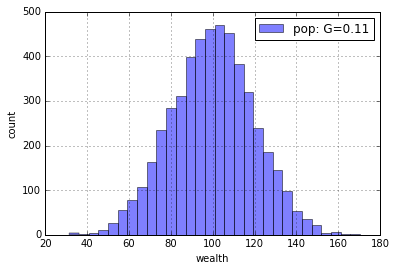

In [4]:
hist(population)

# Transactions

In a transaction, two actors come together and exchange some of their wealth. For now we will use a wealth-conserving transaction function in which all the wealth from both actors is put into a pot, which is then split randomly and uniformly between the two actors:

In [5]:
def random_split(A, B):
    "Take all the money uin the pot and divide it randomly between the two actors."
    pot = A + B
    share = random.uniform(0, pot)
    return share, pot - share

In [6]:
random_split(100, 100)

(95.3251239711815, 104.6748760288185)

# Interactions

How do we decide which parties interact with each other?  We will define an interaction function that, given the size of the population, randomly selects any two actors in the populations (denoted by their index numbers in the list). We'll call this function `anyone`, meaning that any actor can interact with any other actor:

In [7]:
def anyone(N): return random.sample(range(N), 2)

In [8]:
anyone(N)

[3405, 116]

# Simulation

The function `simulate` takes an initial population, calls an interaction function to select two actors, and a transaction function to split their wealth, and repeats this T times. After each transaction, we yield the population, so `simulate` yields the complete history of the simulation.

In [9]:
def simulate(population, T, transaction=random_split, interaction=anyone):
    "Run simulation on population for T transactions; yield (t, pop) at each time step."
    population = population.copy()
    yield population
    for t in range(1, T + 1):
        i, j = interaction(len(population))
        population[i], population[j] = transaction(population[i], population[j]) 
        yield population

Here is a simple example of simulating a population of 4 actors for 8 time steps:

In [10]:
for pop in simulate([100] * 4, 8):
    print(pop)

[100, 100, 100, 100]
[100, 139.34514344135886, 100, 60.65485655864116]
[170.2563182135521, 139.34514344135886, 29.743681786447894, 60.65485655864116]
[105.13376035310705, 139.34514344135886, 29.743681786447894, 125.7774144190862]
[105.13376035310705, 222.24697868451042, 29.743681786447894, 42.875579175934625]
[105.13376035310705, 222.24697868451042, 53.493944819559275, 19.125316142823255]
[105.13376035310705, 182.09114633291017, 53.493944819559275, 59.28114849442351]
[105.13376035310705, 221.7092394595479, 53.493944819559275, 19.663055367785798]
[264.84710771935215, 61.995892093302835, 53.493944819559275, 19.663055367785798]


# SImulation Visualization

If we want to do larger simulations we'll need a better way to visualize the results.
The function `show` does that:

In [11]:
import statistics

def show(population, k=40, percentiles=(1, 10, 50, 90, 99), **kwargs):
    "Run a simulation for k*N steps, printing statistics and displaying a plot and histogram."
    N = len(population)
    start = list(population)
    results = [(t, sorted(pop)) # Sort results so that percentiles work
               for (t, pop) in enumerate(simulate(population, k * N, **kwargs))
               if t % (N / 10) == 0]
    times = [t for (t, pop) in results]
    # Printout:
    print('   t    Gini stdev' + (' {:3d}%' * len(percentiles)).format(*percentiles))
    print('------- ---- -----' + ' ----' * len(percentiles))
    fmt = '{:7,d} {:.2f} {:5.1f}' + ' {:4.0f}' * len(percentiles)
    for (t, pop) in results:
        if t % (4 * N) == 0:
            data = [percent(pct, pop) for pct in percentiles]
            print(fmt.format(t, gini(pop), statistics.stdev(pop), *data))
    # Plot:
    plt.hold(True); plt.xlabel('wealth'); plt.ylabel('time'); plt.grid(True)
    for pct in percentiles:
        line = [percent(pct, pop) for (t, pop) in results]
        plt.plot(line, times)
    plt.show()
    # Histogram:
    R = (min(pop+start), max(pop+start))
    hist(start, 'start', range=R)
    hist(pop, 'end', range=R)
                
def percent(pct, items):
    "The item that is pct percent through the sorted list of items."
    return items[min(len(items)-1, len(items) * pct // 100)]

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.11  19.7   55   74  100  125  145
 20,000 0.50  98.2    1   11   70  230  440
 40,000 0.51 102.6    1   10   69  232  489
 60,000 0.50  98.2    1   11   70  232  453
 80,000 0.50  99.1    1   11   68  230  459
100,000 0.50  99.6    1   11   69  227  472
120,000 0.49  98.3    1   11   71  224  459
140,000 0.50  99.7    1   11   69  229  469
160,000 0.50 101.1    1   11   68  228  484
180,000 0.50 100.4    1   10   68  230  465
200,000 0.50  99.8    1   10   69  230  456


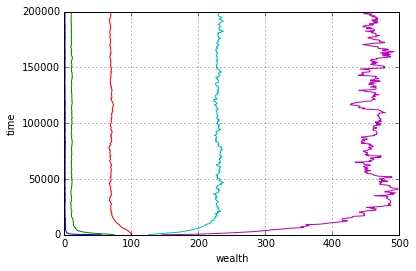

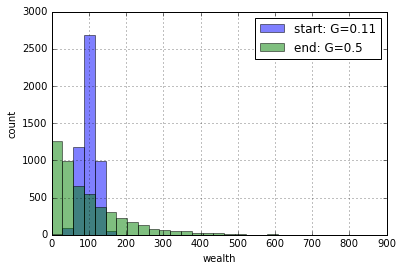

In [12]:
show(population)

There are three parts to this output:

**The printout:** For the starting population and for every 10,000 transactions along the way, we 
print the Gini coefficient and standard deviation of the population, and the wealths at five percentile points in the population: the 1%, 10%, 50% (median), 90% and 99% marks.

**The plot:** This shows the same information as the printout (except for the Gini index), but with more data points along the way. The leftmost (blue) line is the 1% mark, the rightmost (purple) is the 99% mark, and the inner lines are the 10%, 50% and 90% marks, respectively. For the plot, time goes from bottom to top rather than top to bottom. So, the 99% (purple) line starts at around 150, and over time increases to over 400, indicating that the richest 1% are getting richer. The fact that the lines are going more or less straight up after about 50,000 transactions suggests that the system has converged.

**The histogram:** The starting and ending populations are plotted as histograms. 

The results show that income inequality is increasing over time. How can you tell? Because  the Gini coefficient is increasing over time, the standard deviation is increasing, and the 1% and 10% marks are decreasing (the blue and olive lines are moving left as time increases) while the 90% and 99% marks are increasing (the aqua and purple lines are moving right as time increases).

Would the population continue to change if we let the simulation run longer? It looks like only the 1% line is changing, the other lines remain pretty much in one place from about T=15,000 to T=25,000. This suggests that running the simulation longer would not have too much effect.

# Effect of Starting Population

What happens to the final result if we vary the starting population? I'll introduce the function `samples` to sample from a distribution function `n` times, normalizing the result to have the specified mean:

In [13]:
def samples(distribution, *args, n=N, mu=MU):
    "Sample from the distribution n times, then normalize results to have mean mu."
    numbers = [distribution(*args) for _ in range(N)]
    return normalize(numbers, mu)

def normalize(numbers, mu):
    "Make the numbers non-negative, and scale them so they have mean mu."
    numbers = [max(0, n) for n in numbers]
    factor = len(numbers) * mu / sum(numbers)
    return [x * factor for x in numbers]

Now we can easily make an initial population from a distribution function. I'll start with a uniform distribution:

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.34  58.7    2   20   99  182  199
 20,000 0.49  95.7    1   11   72  228  443
 40,000 0.50 100.5    1   10   69  231  460
 60,000 0.50  99.3    1   11   70  232  465
 80,000 0.50 100.1    1   11   69  229  464
100,000 0.50  99.1    1   11   71  233  465
120,000 0.50 100.8    1   11   68  236  471
140,000 0.50 101.1    1   11   67  228  479
160,000 0.50  99.5    1   10   69  230  455
180,000 0.51 102.3    1   11   67  233  475
200,000 0.50  98.7    1   10   71  227  455


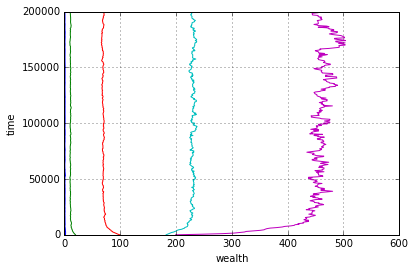

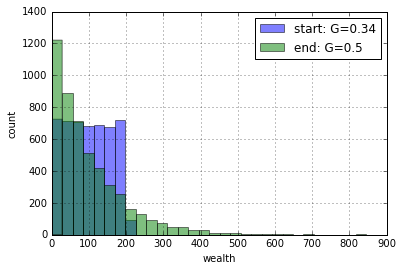

In [14]:
show(samples(random.uniform, 0, 200))

And try a constant distribution, where everyone starts out the same:

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.00   0.0  100  100  100  100  100
 20,000 0.49  94.7    1   12   71  228  425
 40,000 0.50 100.0    1   11   70  226  457
 60,000 0.50 100.5    1   11   69  230  458
 80,000 0.50  99.6    1   11   70  229  450
100,000 0.49  99.3    1   11   70  231  445
120,000 0.50  98.8    1   11   71  231  461
140,000 0.51 101.7    1   10   69  231  472
160,000 0.50  99.0    1   11   68  232  458
180,000 0.50  99.4    1   11   70  229  460
200,000 0.49  99.0    1   12   69  229  449


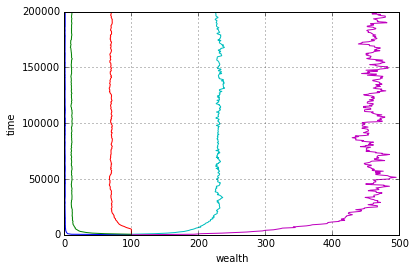

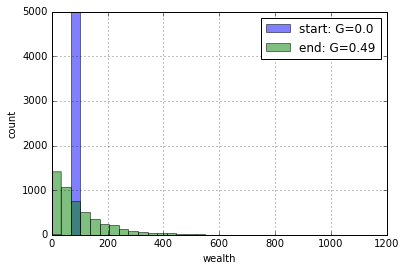

In [15]:
def constant(mu=MU): return mu

show(samples(constant))

The resulting histogram looks different, but only because the starting distribution is so narrow and tall; the end distribution has a Gini coefficient of about 1/2 and standard deviation of about 100, just like we get from the other starting distributions.

Here is one that statisticians call the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) (with carefully chosen parameters):

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.50  99.2    1   10   69  236  430
 20,000 0.50  99.8    1   11   68  230  467
 40,000 0.50 101.2    1   11   70  228  490
 60,000 0.49  96.4    1   11   70  230  433
 80,000 0.50  99.8    1   10   70  227  469
100,000 0.50  98.6    1   10   69  232  459
120,000 0.49  96.3    1   11   71  228  443
140,000 0.50  99.3    1   11   69  232  447
160,000 0.50 101.2    1   10   69  234  460
180,000 0.50  98.6    1   10   69  235  444
200,000 0.50  99.2    1   11   69  230  467


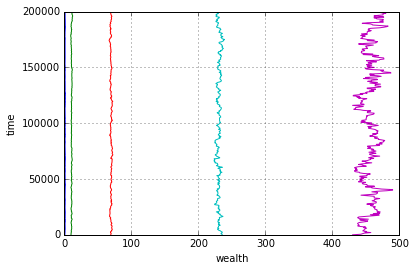

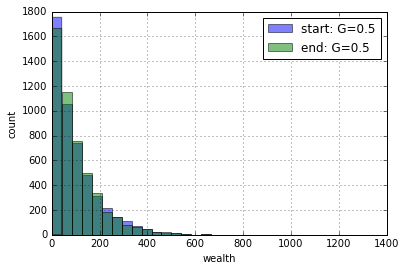

In [16]:
def beta(): return random.betavariate(0.9, 12)
    
show(samples(beta))

**Surprise:** We can confirm that the starting population doesn't matter much. I thought it would make a real difference, but we showed that three very different starting populations&mdash;Gaussian, uniform, and beta&mdash;all ended up with very similar final populations; all with G around 1/2 and standard deviation around 100. The final distribution in all three cases looks similar to the normalized beta(0.9, 12) distribution.

# Effect of Transaction Function

Does the transaction function have an effect on the outcome? So far we've only used the `random_split` transaction function; we'll now compare that to the `winner_take_all` function, in which the wealth from both actors is thrown into a pot, and one of them takes all of it:

In [17]:
def winner_take_all(A, B): return random.choice(([A + B, 0], [0, A + B]))

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.11  19.7   55   74  100  125  145
 20,000 0.89 282.9    0    0    0  374 1411
 40,000 0.94 403.7    0    0    0  111 1946
 60,000 0.96 473.6    0    0    0    0 2627
 80,000 0.97 555.7    0    0    0    0 2986
100,000 0.97 611.4    0    0    0    0 3485
120,000 0.98 694.3    0    0    0    0 3592
140,000 0.98 762.0    0    0    0    0 3670
160,000 0.98 799.5    0    0    0    0 3603
180,000 0.99 844.0    0    0    0    0 3603
200,000 0.99 890.0    0    0    0    0 3677


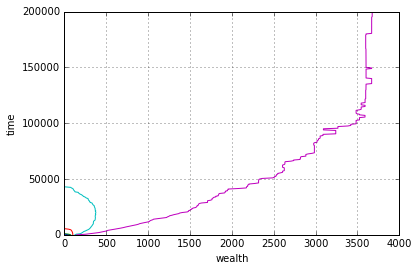

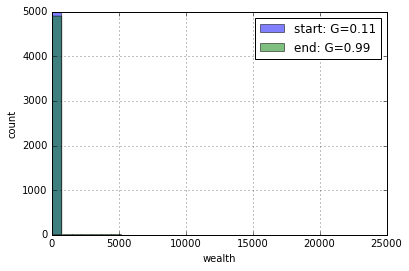

In [18]:
show(population, transaction=winner_take_all)

Now the results look **very** different: most of the wealth goes to the 99th percentile (purple line on the far right of  the plot), with everybody else getting wiped out (although the 90th percentile holds out until around 50,000 transactions). The Gini coefficient is all the way up to 0.99 and the standard deviation is over 800, and still rising.

That makes sense: any time two actors with non-zero wealth interact, one of them will end up with zero&mdash;the number of actors with zero wealth increases monotonically until all the wealth is with one actor, and from then on the wealth just gets swapped around.

At the other end of the spectrum, let's try a transaction function, `redistribute`, that taxes both parties 31% (the average income tax rate in the US) and splits that tax revenue evenly among the two parties; the non-taxed part is split with `random_split`:

In [19]:
def redistribute(A, B, rate=0.31):
    "Tax both parties at rate; split the tax revenue evenly, and randomly split the rest."
    tax = rate * (A + B)
    Arand, Brand = random_split(A + B - tax, 0)
    return tax / 2 + Arand, tax / 2 + Brand

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.11  19.7   55   74  100  125  145
 20,000 0.33  60.2   17   36   86  182  288
 40,000 0.33  62.2   17   35   86  186  302
 60,000 0.33  60.7   17   35   87  185  289
 80,000 0.33  61.8   17   35   86  183  291
100,000 0.33  61.0   18   35   85  182  293
120,000 0.33  61.1   17   34   87  185  288
140,000 0.33  60.8   17   35   86  183  295
160,000 0.33  61.4   16   34   86  185  297
180,000 0.33  61.4   17   36   86  184  292
200,000 0.33  61.9   18   34   85  187  288


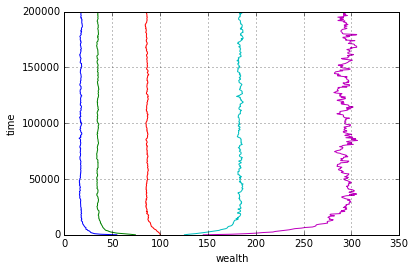

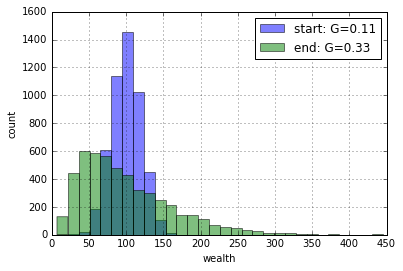

In [20]:
show(population, transaction=redistribute)

**Another surprise:** This transaction function does indeed lead to less inequality than `split_randomly` or `winner_take_all`, but surpprisingly (to me) it still increases inequality compared to the initial (Gaussian) population.

Here's one more interaction function, `status_quo`, in which both actors keep half of their wealth out of the transaction, and the other half is randomly split using a triangular distribution in such a way that the most likely outcome is that each actor keeps what they started with, but from there probability falls off on either side, making larger and larger deviations from the status quo less and less likely:

In [21]:
def status_quo(A, B):
    "A transaction that is most likely to leave things unchanged, but could move any amount of wealth around."
    a = random.triangular(0, (A + B) / 2, A / 2)
    return (A / 2 + a), (A + B) - (A / 2 + a)

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.11  19.7   55   74  100  125  145
 20,000 0.21  38.5   33   55   95  151  209
 40,000 0.22  40.3   31   53   94  154  219
 60,000 0.22  40.3   31   53   94  154  214
 80,000 0.23  41.0   31   52   94  155  220
100,000 0.23  40.8   30   52   94  156  216
120,000 0.23  40.9   31   53   94  154  220
140,000 0.23  41.3   31   52   95  153  223
160,000 0.22  40.5   32   53   95  153  213
180,000 0.22  40.3   32   53   94  155  213
200,000 0.23  40.9   32   52   94  156  216


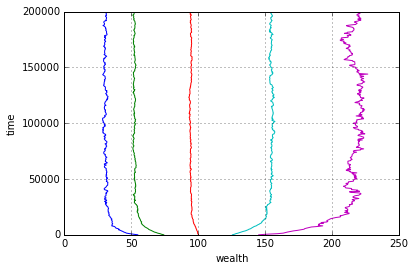

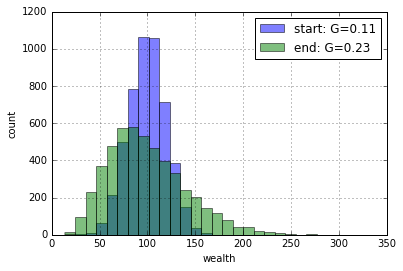

In [22]:
show(population, transaction=status_quo)

The `status_quo` transaction increases inequality from the initial population, but not as much as the other transaction functions.

# Effect of Interaction Function

We have been using `anyone` as our interaction function: anyone can enter into a transaction with anyone else. Suppose that transactions are constrained to be *local*&mdash;that you can only do business with your close neighbors.  Will that make income more equitable, because there will be no large, global conglomorates?  

In [23]:
def neighborhood(n, width=5): 
    "Choose two agents in the same neighborhood"
    i = random.randrange(n - width)
    return random.sample(range(i, i + width + 1), 2)

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.11  19.7   55   74  100  125  145
 20,000 0.48  93.2    1   11   72  224  415
 40,000 0.48  93.6    1   11   71  227  423
 60,000 0.49  95.7    1   11   72  225  432
 80,000 0.49  96.2    1   11   71  226  442
100,000 0.49  95.4    1   12   71  229  430
120,000 0.49  96.0    1   10   70  229  432
140,000 0.50  97.5    1   11   70  235  430
160,000 0.50  97.5    1   11   70  234  448
180,000 0.50  98.3    1   11   71  232  453
200,000 0.49  96.5    1   11   71  229  442


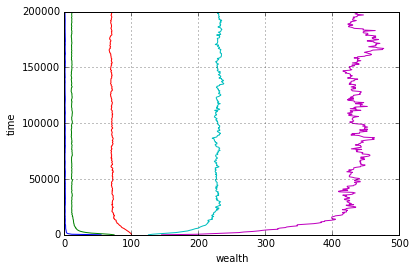

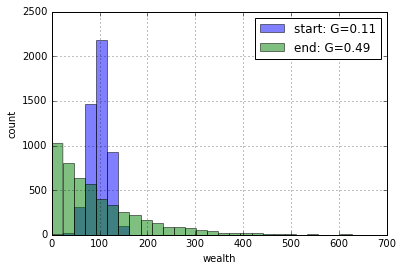

In [24]:
show(population, interaction=neighborhood)

**Surprise:** The `neighborhood` interaction is not too different from the `anyone` interaction.  

Let's get even more local, allowing trade only with your immediate neighbor (to either side):

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.11  19.7   55   74  100  125  145
 20,000 0.45  84.0    1   13   79  217  364
 40,000 0.47  90.1    1   11   75  223  399
 60,000 0.47  90.8    1   12   74  226  401
 80,000 0.49  94.9    1   11   72  229  437
100,000 0.48  93.0    1   12   73  222  431
120,000 0.48  93.0    1   12   73  228  424
140,000 0.48  93.3    1   10   73  228  421
160,000 0.48  94.2    1   11   72  226  430
180,000 0.49  93.2    1   11   72  231  416
200,000 0.48  92.7    1   11   72  225  412


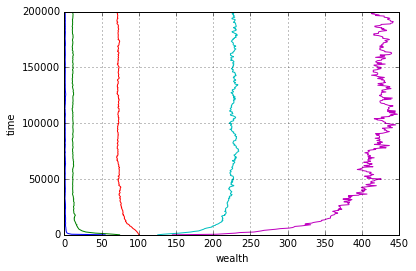

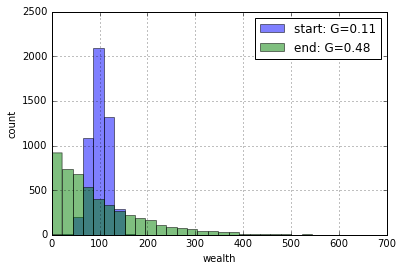

In [25]:
def adjacent(n): return neighborhood(n, 1)
    
show(population, interaction=adjacent)

It is still surprising that we still have no efect from restricting trade.

# United States Distribution

We've drawn from mathematical distributions; let's look at the actual distribution of family income in the United States. Each row in the following table is a tuple giving the lower bound and upper bound (in thousands of dollars of income), followed by the cumulative percentage of families in the row or a previous row. The table I got this from actually had "\$250,000 or above" as the final row; I had to cut it off somewhere, and arbitrarily chose \$300,000.

In [26]:
USA_table = [  
  (0,    10,  7.63),
  (10,   20, 19.20),
  (20,   30, 30.50),
  (30,   40, 41.08),
  (40,   50, 49.95),
  (50,   60, 57.73),
  (60,   70, 64.56),
  (70,   80, 70.39),
  (80,   90, 75.02),
  (90,  100, 79.02),
  (100, 110, 82.57),
  (110, 120, 85.29),
  (120, 130, 87.60),
  (130, 140, 89.36),
  (140, 150, 90.95),
  (150, 160, 92.52),
  (160, 170, 93.60),
  (170, 180, 94.55),
  (180, 190, 95.23),
  (190, 200, 95.80),
  (200, 250, 97.70),
  (250, 300, 100.0)]

def USA():
    "Sample from the USA distribution."
    p = random.uniform(0, 100)
    for (lo, hi, cum_pct) in USA_table:
        if p <= cum_pct:
            return random.uniform(lo, hi) 

Let's see what it looks like:

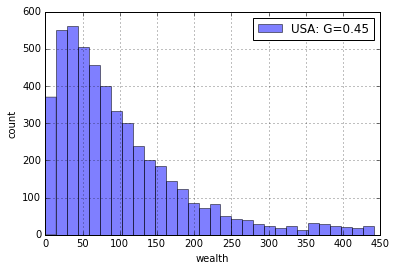

In [27]:
hist(samples(USA), label='USA')

Hey&mdash;that looks like the beta distribution. Let's compare:

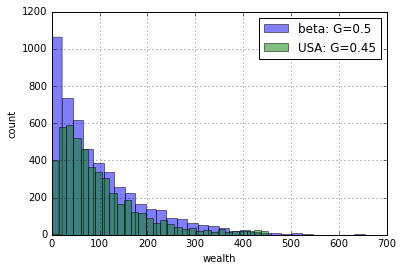

In [28]:
hist(samples(beta), label='beta')
hist(samples(USA), label='USA')

   t    Gini stdev   1%  10%  50%  90%  99%
------- ---- ----- ---- ---- ---- ---- ----
      0 0.46  89.5    2   17   74  219  422
 20,000 0.50 100.0    1   11   69  227  478
 40,000 0.50  99.9    1   11   69  229  463
 60,000 0.50 101.5    1   11   68  232  465
 80,000 0.50  99.7    1   11   69  230  463
100,000 0.50 101.0    1   10   70  228  472
120,000 0.50 100.0    1   11   68  236  448
140,000 0.50 100.7    1   10   70  233  479
160,000 0.50 100.7    1   11   69  228  455
180,000 0.50 100.3    1   10   69  233  457
200,000 0.50 100.3    1   11   69  228  468


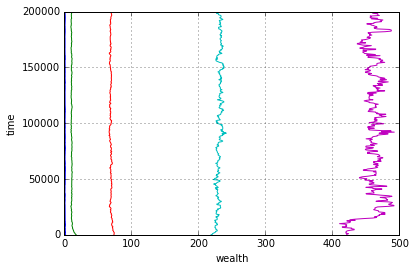

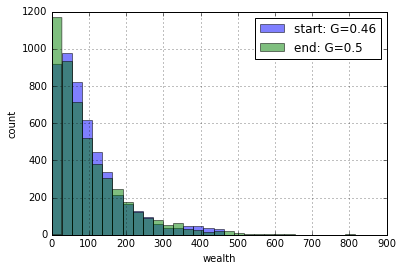

In [29]:
show(samples(USA))

The USA distribution is indeed similar to the beta(0.9, 12) distribution, and to the stationary ending distribution.

# A Mathematician, a Statistician, and a Programmer walk into a problem ...

In 2013, mathematician George Andrew's editorial *[Drowning in the Data Deluge](http://www.ams.org/notices/201207/rtx120700933p.pdf)* complains of an "overblown enthusiasm for data analysis." The tone was that this new fad for "big data" was taking away from traditional mathematics.

Two Stanford professors, mathematician Persi Diaconis and 
statistician Susan Holmes, were more accepting of new ideas. The three of us got to discussing Andrew's editorial and the differences between mathematical, statistical, and computational thinking. At the time, I had just heard about the economics problem covered in this notebook, and I suggested the three of us work on it, and compare approaches and results.
In the end, all three of us found similar results, in that we all identified the shape of the final distribution. But there were differences in how we got there:

**Mathematical thinking** (Persi):

- **Tool:** Paper and pencil.
- **Notes:** The process can be modeled by a Markov chain, using the same techniques as in [this paper](http://statweb.stanford.edu/~cgates/PERSI/papers/kac10.pdf). In the limit, there is a difference between the continuous case (where money is a real number, and the distribution is stationary), and the discrete case (where money comes in integer amounts and the distribution is not ergodic as there is an absorbing state). 

**Statistical thinking** (Susan):

- **Tool:** Simulation in `R`, with N=10 actors for T=1,000 transactions.
- **Notes**: this is extremely similar to what happens for random genetic drift in generations, that also gives clumping (and extinction of some of the alleles).

**Computational thinking** (Peter):

- **Tool:** Simulation in `IPython`, with N=5000 actors for T=200,000 transactions.
- **Notes**: Results are very similar to Susan's, but with more variations explored and more pretty pictures.